# Libraries

In [1]:
! pip install transformers timm --quiet
! pip install ipywidgets --quiet
! pip install -U albumentations --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.0/284.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 16.8 MB/s eta 0:00:00


In [2]:
# Standard Libraries
import os
import random
from collections import Counter

# Numerical and Data Handling Libraries
import numpy as np
import pandas as pd

# Image Processing Libraries
import cv2
from PIL import Image

# Plotting and Visualization
import matplotlib.pyplot as plt

# PyTorch and Torchvision
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Transformers for Vision Models
from transformers import ViTConfig, ViTForImageClassification, ViTImageProcessor

# Utility Libraries
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# jupyter nbextension enable --py widgetsnbextension
from google.colab import output
output.enable_custom_widget_manager()

# Data Import

In [3]:
train_dir = "/kaggle/input/croped-processed-augmented-bird-dataset/archive/Augmented_CropImage_Processed_Dataset/train_images"
val_dir = "/kaggle/input/croped-processed-augmented-bird-dataset/archive/Augmented_CropImage_Processed_Dataset/val_images"
test_dir = "/kaggle/input/croped-processed-augmented-bird-dataset/archive/Augmented_CropImage_Processed_Dataset/test_images/mistery_cat"

# Model Import

In [4]:
from transformers import AutoImageProcessor, SwinForImageClassification

def load_model_and_processor(model_name: str, num_labels: int = 20):
    processor = AutoImageProcessor.from_pretrained(model_name)
    model = SwinForImageClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        ignore_mismatched_sizes=True  
    )

    model.classifier = torch.nn.Linear(model.config.hidden_size, num_labels)
    torch.nn.init.xavier_uniform_(model.classifier.weight)  
    torch.nn.init.zeros_(model.classifier.bias)

    return processor, model

In [5]:
# import timm
# model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=20)

## Freeze all feature layers of Swin

In [6]:
def configure_trainable_layers(model):
    """
    Configures the Swin model by freezing all layers except for the last stage and the classifier.
    :param model: SwinForImageClassification model.
    """
    for param in model.swin.parameters():
        param.requires_grad = False
    
    if hasattr(model.swin, "stages"):
        for param in model.swin.stages[-2].parameters():
            param.requires_grad = True
        print("Unfroze the last stage of the Swin backbone.")
    
    for param in model.classifier.parameters():
        param.requires_grad = True

# optimizer_setup.py
from torch.optim import AdamW  # Use PyTorch's AdamW

## Set layer-wise learning rate

In [7]:
import torch.optim.lr_scheduler as lr_scheduler

def create_optimizer(model, feature_lr: float = 1e-5, classifier_lr: float = 3e-4):
    """
    Creates an AdamW optimizer using PyTorch's implementation.
    :param model: SwinForImageClassification model.
    :param feature_lr: Learning rate for feature extractor layers.
    :param classifier_lr: Learning rate for classifier head.
    :return: Tuple (optimizer, scheduler)
    """
    optimizer = AdamW(
        [
            {"params": model.swin.parameters(), "lr": feature_lr, "weight_decay": 0.01},
            {"params": model.classifier.parameters(), "lr": classifier_lr, "weight_decay": 0.01}
        ]
    )
    
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)
    
    return optimizer, scheduler

In [8]:
MODEL_NAME = "Emiel/cub-200-bird-classifier-swin"
NUM_LABELS = 20

processor, model = load_model_and_processor(MODEL_NAME, NUM_LABELS)
configure_trainable_layers(model)
optimizer, scheduler = create_optimizer(model)

preprocessor_config.json:   0%|          | 0.00/386 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.95k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/786M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at Emiel/cub-200-bird-classifier-swin and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([200]) in the checkpoint and torch.Size([20]) in the model instantiated
- classifier.weight: found shape torch.Size([200, 1536]) in the checkpoint and torch.Size([20, 1536]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Process Training Data

In [9]:
submission_class_order = [
    'Groove_billed_Ani',
    'Red_winged_Blackbird',
    'Rusty_Blackbird',
    'Gray_Catbird',
    'Brandt_Cormorant',
    'Eastern_Towhee',
    'Indigo_Bunting',
    'Brewer_Blackbird',
    'Painted_Bunting',
    'Bobolink',
    'Lazuli_Bunting',
    'Yellow_headed_Blackbird',
    'American_Crow',
    'Fish_Crow',
    'Brown_Creeper',
    'Yellow_billed_Cuckoo',
    'Yellow_breasted_Chat',
    'Black_billed_Cuckoo',
    'Gray_crowned_Rosy_Finch',
    'Bronzed_Cowbird'
]

In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BirdDataset(Dataset):
    def __init__(self, main_dir, transform=None):
        self.dataset = ImageFolder(root=main_dir)  # Remove transform here
        self.class_to_idx = self.dataset.class_to_idx
        self.transform = transform  # Store the transform separately
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = np.array(image)  # Convert PIL image to NumPy
        
        if self.transform:
            augmented = self.transform(image=image)  # Albumentations requires a dictionary
            image = augmented["image"]
        
        return image, label



# Define an Albumentations transformation pipeline
albumentations_transform = A.Compose([
    A.Resize(height=420, width=420),  
    A.RandomResizedCrop(size=(384, 384), scale=(0.8, 1.0)),  
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.Affine(scale=(0.9, 1.1), translate_percent=(0.1, 0.1), rotate=(-15, 15), p=0.5),  
    A.MotionBlur(p=0.2),  
    A.CLAHE(p=0.2),  
    A.RandomBrightnessContrast(p=0.3),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
    A.CoarseDropout(num_holes_range=(2, 5), hole_height_range=(10, 40), hole_width_range=(10, 40), p=0.5),
    A.Normalize(mean=processor.image_mean, std=processor.image_std),
    ToTensorV2(),
])


# Wrapper to use Albumentations with PyTorch Dataset
class AlbumentationsWrapper:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img):
        img = np.array(img)  # Convert PIL Image to NumPy
        augmented = self.transform(image=img)
        return augmented["image"]
        
val_transform = transforms.Compose([
    transforms.Resize((384, 384)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

train_dataset = BirdDataset(train_dir, transform=albumentations_transform)
val_dataset = BirdDataset(val_dir, transform=val_transform)

def validate_class_order(train_class_order, submission_order):
    """Make sure the category names and order of both lists are exactly the same"""
    if len(train_class_order) != len(submission_order):
        raise ValueError(f"The number of categories does not match! Training set: {len(train_class_order)}, Submission Requirements: {len(submission_order)}")
    
    for train_cls, sub_cls in zip(train_class_order, submission_order):
        if train_cls != sub_cls:
            raise ValueError(f"Inconsistent order: training set '{train_cls}' vs Submission Requirements '{sub_cls}'")
    return True

train_class_order = sorted(train_dataset.class_to_idx.keys())

try:
    validate_class_order(train_class_order, submission_class_order)
except ValueError as e:
    print("Category order inconsistency detected, automatically correcting...")
    from torchvision.datasets import DatasetFolder
    
    class OrderedImageFolder(DatasetFolder):
        """Forces the data sets of categories to be loaded in a specified order"""
        def __init__(self, root, class_order, transform=None):
            self.class_order = class_order
            super().__init__(
                root,
                loader=lambda x: Image.open(x).convert("RGB"),
                extensions=('jpg', 'jpeg', 'png'),
                transform=transform,
                target_transform=None
            )
            
        def find_classes(self, directory):
            classes = self.class_order 
            class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
            return classes, class_to_idx
    
    train_dataset = OrderedImageFolder(
        train_dir, 
        class_order=submission_class_order,
        transform=AlbumentationsWrapper(albumentations_transform)  # Use wrapper
    )


    val_dataset = OrderedImageFolder(
        val_dir,
        class_order=submission_class_order,
        transform=val_transform
    )
    
    print("Corrected category order：", train_dataset.classes)
    
# Category index validation (ensuring consistency with submission format)
assert sorted(train_dataset.class_to_idx.keys()) == sorted(submission_class_order), "Category order mismatch！"

Category order inconsistency detected, automatically correcting...
Corrected category order： ['Groove_billed_Ani', 'Red_winged_Blackbird', 'Rusty_Blackbird', 'Gray_Catbird', 'Brandt_Cormorant', 'Eastern_Towhee', 'Indigo_Bunting', 'Brewer_Blackbird', 'Painted_Bunting', 'Bobolink', 'Lazuli_Bunting', 'Yellow_headed_Blackbird', 'American_Crow', 'Fish_Crow', 'Brown_Creeper', 'Yellow_billed_Cuckoo', 'Yellow_breasted_Chat', 'Black_billed_Cuckoo', 'Gray_crowned_Rosy_Finch', 'Bronzed_Cowbird']



Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.79      0.92      0.85        12
           2       1.00      0.33      0.50        12
           3       0.92      1.00      0.96        12
           4       0.91      0.91      0.91        11
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00        12
           7       0.43      0.50      0.46        12
           8       0.92      1.00      0.96        12
           9       0.92      1.00      0.96        12
          10       1.00      1.00      1.00        12
          11       0.92      1.00      0.96        11
          12       0.67      0.50      0.57        12
          13       0.55      0.50      0.52        12
          14       1.00      1.00      1.00        12
          15       0.61      0.92      0.73        12
          16       0.92      1.00      0.96        11
  

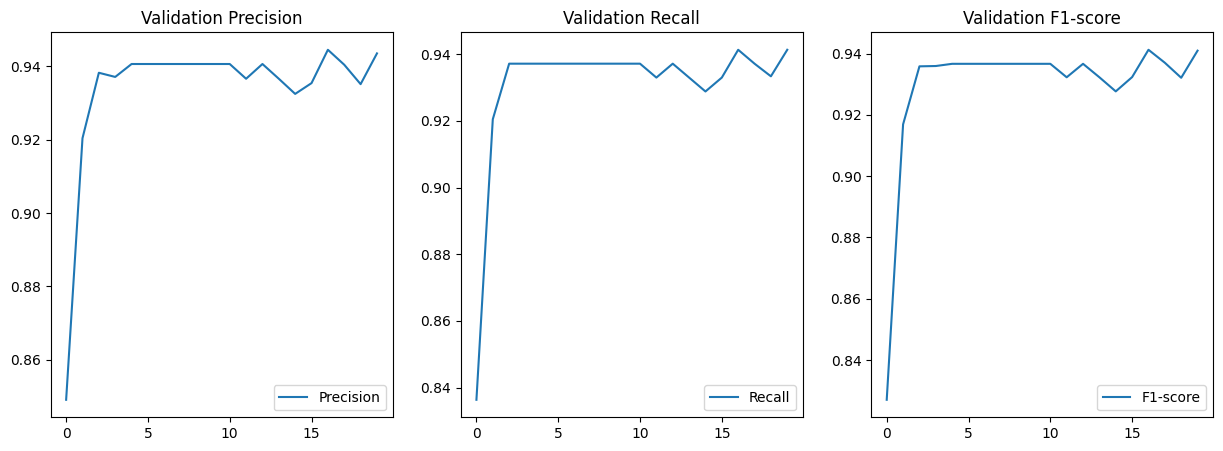

In [11]:
import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# (Assuming train_dataset, val_dataset, model, optimizer, criterion, etc. are already defined)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

criterion = torch.nn.CrossEntropyLoss()
model = model.to(device)

class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train_epoch(model, loader, optimizer, scaler, scheduler):
    model.train()
    total_loss = 0
    correct = 0
    
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.amp.autocast(device_type="cuda"):
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
    
    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    
    scheduler.step()
    
    return avg_loss, accuracy

def validate(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            with torch.amp.autocast(device_type="cuda"):  # Mixed precision
                outputs = model(images)
                loss = criterion(outputs.logits, labels)
            
            total_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)

    # Compute Precision, Recall, and F1-score
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")

    # Print detailed classification report
    print("\nClassification Report:\n", classification_report(all_labels, all_preds))

    return avg_loss, accuracy, precision, recall, f1

scaler = torch.amp.GradScaler()  # Correct initialization
early_stopper = EarlyStopper(patience=10, min_delta=0.0003)
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# Variables to track the best validation accuracy
best_val_acc = 0.0
best_model_path = "/kaggle/working/best_model.pth"

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [],
           'val_precision': [], 'val_recall': [], 'val_f1': []}

for epoch in range(20):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scaler, scheduler)
    val_loss, val_acc, val_precision, val_recall, val_f1 = validate(model, val_loader)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['val_precision'].append(val_precision)
    history['val_recall'].append(val_recall)
    history['val_f1'].append(val_f1)
    
    print(f"Epoch {epoch+1:02d}:")
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
    print(f"Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1-score: {val_f1:.4f}\n")
    
    # 保存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with validation accuracy: {val_acc:.4f}")
    
    if early_stopper.early_stop(val_loss):
        print("Early stopping triggered!")
        break

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history['val_precision'], label='Precision')
plt.title('Validation Precision')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['val_recall'], label='Recall')
plt.title('Validation Recall')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history['val_f1'], label='F1-score')
plt.title('Validation F1-score')
plt.legend()

plt.show()

In [12]:
import os
import torch

# Define the directory where you'll save the best model in Hugging Face format.
save_dir = "/kaggle/working/swin_model"
os.makedirs(save_dir, exist_ok=True)

# Load the best model state dictionary (from the training loop).
best_state_dict = torch.load(best_model_path, map_location=torch.device("cpu"))
model.load_state_dict(best_state_dict)

# Save the best model in Hugging Face format.
model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)

# Optionally, save additional information such as class mapping and training configuration.
class_info = {
    "class_order": submission_class_order,
    "class_to_idx": train_dataset.class_to_idx,
    "idx_to_class": {v: k for k, v in train_dataset.class_to_idx.items()}
}
torch.save(class_info, os.path.join(save_dir, "class_info.pth"))

train_config = {
    "epochs_trained": len(history['train_loss']),
    "best_val_acc": max(history['val_acc']),
    "optimizer_state": optimizer.state_dict()
}
torch.save(train_config, os.path.join(save_dir, "train_config.pth"))

# Also save the class order as a plain text file for reference.
with open(os.path.join(save_dir, "class_info.txt"), "w") as f:
    f.write("\n".join(submission_class_order))

print(f"Best model saved in Hugging Face format to: {save_dir}")

<ipython-input-12-cf258f9b96a8>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state_dict = torch.load(best_model_path, map_location=torch.device("cpu"))


Best model saved in Hugging Face format to: /kaggle/working/swin_model


# Test and Generate Submission File

In [13]:
import os
import torch
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import AutoImageProcessor, SwinForImageClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

submission_class_order = [
    'Groove_billed_Ani',
    'Red_winged_Blackbird',
    'Rusty_Blackbird',
    'Gray_Catbird',
    'Brandt_Cormorant',
    'Eastern_Towhee',
    'Indigo_Bunting',
    'Brewer_Blackbird',
    'Painted_Bunting',
    'Bobolink',
    'Lazuli_Bunting',
    'Yellow_headed_Blackbird',
    'American_Crow',
    'Fish_Crow',
    'Brown_Creeper',
    'Yellow_billed_Cuckoo',
    'Yellow_breasted_Chat',
    'Black_billed_Cuckoo',
    'Gray_crowned_Rosy_Finch',
    'Bronzed_Cowbird'
]

model_dir = "/kaggle/working/swin_model" 
processor = AutoImageProcessor.from_pretrained(model_dir)

expected_size = 384
val_transform = transforms.Compose([
    transforms.Resize((expected_size, expected_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

class CompetitionTestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.image_files = sorted(os.listdir(test_dir))  # 保持严格顺序
        self.image_paths = [os.path.join(test_dir, f) for f in self.image_files]
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, os.path.basename(self.image_paths[idx])

def load_trained_model(model_dir, class_order):
    model = SwinForImageClassification.from_pretrained(model_dir).to(device)
    
    config = model.config
    if config.id2label != {i: cls for i, cls in enumerate(class_order)}:
        print("Warning: The order of categories in the model configuration is inconsistent with the submission requirements. Overriding with submission order.")
        config.id2label = {i: cls for i, cls in enumerate(class_order)}
        config.label2id = {cls: i for i, cls in enumerate(class_order)}
    
    model.eval()
    return model

def generate_submission(test_dir, model_dir, output_csv="submission.csv"):
    test_dataset = CompetitionTestDataset(test_dir, transform=val_transform)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)
    
    model = load_trained_model(model_dir, submission_class_order)
    
    filenames = []
    predictions = []
    
    with torch.no_grad():
        for images, paths in test_loader:
            outputs = model(images.to(device))
            batch_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            filenames.extend(paths)
            predictions.extend(batch_preds.tolist())
    
    submission_df = pd.DataFrame({
        'path': filenames,
        'class_idx': predictions
    })
    
    print("\nValidation Results:")
    print(f"Total Samples: {len(submission_df)}")
    print(f"Number of unique file names: {submission_df['path'].nunique()}")
    print(f"Predicted category distribution:\n{submission_df['class_idx'].value_counts().sort_index()}")
    
    submission_df.to_csv(output_csv, index=False)
    print(f"\nSubmission CSV saved to: {output_csv}")

if __name__ == "__main__":
    test_dir = "/kaggle/input/croped-processed-augmented-bird-dataset/archive/Augmented_CropImage_Processed_Dataset/test_images/mistery_cat"
    generate_submission(test_dir, model_dir)


Validation Results:
Total Samples: 400
Number of unique file names: 400
Predicted category distribution:
class_idx
0     19
1     17
2     27
3     19
4     23
5     23
6     15
7     19
8     20
9     21
10    19
11    17
12    20
13    18
14    20
15    23
16    20
17    17
18    20
19    23
Name: count, dtype: int64

Submission CSV saved to: submission.csv
